In [1]:
from rmgpy.species import Species
from rmgpy.molecule.parser import *
from rmgpy.molecule.generator import *
from rmgpy.molecule.inchi import compose_aug_inchi, P_LAYER_PREFIX, P_LAYER_SEPARATOR, U_LAYER_PREFIX, U_LAYER_SEPARATOR
from rmgpy.molecule import Molecule
from rmgpy.molecule.resonance import *
from IPython.display import display, HTML, Image, display_html
import re
import itertools
from operator import itemgetter

In [2]:
# inchiparsingTest.py, line 42, `def compare(self, inchi, u_indices=None, p_indices = None):`
def compare_tst(inchi, u_indices=None, p_indices = None):        

    u_layer = U_LAYER_PREFIX + U_LAYER_SEPARATOR.join(map(str, u_indices)) if u_indices else None
    p_layer = P_LAYER_PREFIX + P_LAYER_SEPARATOR.join(map(str, p_indices)) if p_indices else None

    aug_inchi = compose_aug_inchi(inchi, u_layer, p_layer)

    mol = fromAugmentedInChI(Molecule(), aug_inchi)
    ConsistencyChecker.check_multiplicity(mol.getRadicalCount(), mol.multiplicity)

    for at in mol.atoms:
        ConsistencyChecker.check_partial_charge(at)

    spc = Species(molecule=[mol])
    spc.generateResonanceIsomers()

    ignore_prefix = r"(InChI=1+)(S*)/"
    aug_inchi_expected = re.split(ignore_prefix, aug_inchi)[-1]
    print "aug_inchi_expected: ", aug_inchi_expected
    
   # aug_inchi_computed = re.split(ignore_prefix, spc.getAugmentedInChI())[-1]
    aug_inchi_computed = re.split(ignore_prefix, generate_aug_inchi_tst(spc))[-1]
    print "aug_inchi_computed: ", aug_inchi_computed

    if aug_inchi_expected != aug_inchi_computed:
        print "\nError: aug_inchi_expected != aug_inchi_computed"
    else:
        print "\nOK!"

    return mol

In [3]:
# species.py line 530, 'def getAugmentedInChI(self):'
#if self.aug_inchi is None:
#    self.aug_inchi = self.generate_aug_inchi()
#return self.aug_inchi


# species.py line 535, 'def generate_aug_inchi(self):'
def generate_aug_inchi_tst(self):
    candidates = []
    self.generateResonanceIsomers()
    for mol in self.molecule:
        #print mol
        #display(mol)
        try:
           # cand = [mol.toAugmentedInChI(),mol]
            cand = [toAugmentedInChI_tst(mol),mol]
        except ValueError:
            pass  # not all resonance structures can be parsed into InChI (e.g. if containing a hypervalance atom)
        else:
            candidates.append(cand)
    candidates = sorted(candidates, key=itemgetter(0))
    for cand in candidates:
        if all(atom.charge == 0 for atom in cand[1].vertices):
            return cand[0]
    return candidates[0][0]

In [4]:
# molecule.py line 1387, 'def toAugmentedInChI(self):'
#return generator.toAugmentedInChI(self)


# generator.py line 173, 'def toAugmentedInChI(mol):'
def toAugmentedInChI_tst(mol):
    inchi = toInChI(mol)
    #print inchi
    ulayer, player = create_augmented_layers_tst(mol)
    aug_inchi = inchiutil.compose_aug_inchi(inchi, ulayer, player)
    return aug_inchi

In [5]:
# generator.py line 604, 'def create_augmented_layers(mol):'
def create_augmented_layers_tst(mol):
    if mol.getRadicalCount() == 0 and not has_unexpected_lone_pairs(mol):
        return None, None
    elif mol.getFormula() == 'H':
        return inchiutil.U_LAYER_PREFIX + '1', None
    else:
        molcopy = mol.copy(deep=True)

        hydrogens = filter(lambda at: at.number == 1, molcopy.atoms)
        [molcopy.removeAtom(h) for h in hydrogens]

        rdkitmol = toRDKitMol(molcopy)
        _, auxinfo = Chem.MolToInchiAndAuxInfo(rdkitmol, options='-SNon')# suppress stereo warnings
        
        # extract the atom numbers from N-layer of auxiliary info:
        atom_indices = inchiutil.parse_N_layer(auxinfo)    
        atom_indices = [atom_indices.index(i + 1) for i, atom in enumerate(molcopy.atoms)]

        # sort the atoms based on the order of the atom indices
        molcopy.atoms = [x for (y,x) in sorted(zip(atom_indices, molcopy.atoms), key=lambda pair: pair[0])]
    
        #print "molcopy: ", molcopy
        #print "auxinfo: ", auxinfo    
    
      #  ulayer = create_U_layer(molcopy, auxinfo)
        ulayer = create_U_layer_tst(molcopy, auxinfo)

        player = create_P_layer(molcopy, auxinfo)

        return ulayer, None

In [6]:
# generator.py line 123, 'def create_U_layer(mol, auxinfo):'
def create_U_layer_tst(mol, auxinfo):
    if mol.getRadicalCount() == 0:
        return None
    elif mol.getFormula() == 'H':
        return inchiutil.U_LAYER_PREFIX + '1'

    # find the resonance isomer with the lowest u index:
   # minmol = generate_minimum_resonance_isomer(mol)
    minmol = generate_minimum_resonance_isomer_tst(mol)
    
    # create preliminary u-layer:
    u_layer = []
    for i, at in enumerate(minmol.atoms):
        u_layer.extend([i+1] * at.radicalElectrons)
    
    # extract equivalent atom pairs from E-layer of auxiliary info:
    equivalent_atoms = inchiutil.parse_E_layer(auxinfo)
    if equivalent_atoms:
        # select lowest u-layer:
        u_layer = find_lowest_u_layer(minmol, u_layer, equivalent_atoms)

    return (inchiutil.U_LAYER_PREFIX + ','.join(map(str, u_layer)))

In [7]:
# generator.py line 504, 'def generate_minimum_resonance_isomer(mol):'
def generate_minimum_resonance_isomer_tst(mol):
    #print "generating_minimum_resonance_isomer_tst..."
    candidates = generateIsomorphicResonanceStructures_tst(mol)

    sel = mol
    metric_sel = get_unpaired_electrons(sel)
    charge_sel = sum([abs(atom.charge) for atom in sel.vertices])
    for cand in candidates:
        metric_cand = get_unpaired_electrons(cand)
        if metric_cand < metric_sel:
            charge_cand = sum([abs(atom.charge) for atom in cand.vertices])
            if charge_cand <= charge_sel:
                sel = cand
                metric_sel = metric_cand
                charge_sel = charge_cand
    return sel

In [10]:
# resonance.py line 690, 'def generateIsomorphicResonanceStructures(mol):'
def generateIsomorphicResonanceStructures_tst(mol):
    isomorphic_isomers = [mol]# resonance isomers that are isomorphic to the parameter isomer.

    isomers = [mol]
       

    # Iterate over resonance isomers
    index = 0
    while index < len(isomers):
  #  while index < len(isomers) and index < 20:
        isomer = isomers[index]
        print "**************************\nlooping index {0}".format(index)
        print "isomer is:"
        display(isomer)
        
        newIsomers = []
        for algo in populateResonanceAlgorithms():
            newIsomers.extend(algo(isomer))
        print "extended resonance structures for isomer, called newIsomers".format(index)
            
        for newIsomer in newIsomers:
            print "Looping newIsomers. newIsomer is:"
            display(newIsomer)
            # Append to isomer list if unique
            for isom in isomers:
                if isom.copy(deep=True).isIsomorphic(newIsomer.copy(deep=True)):
                    print "newIsomer is isomorphic with isom:"
                    display(isom)
                    isomorphic_isomers.append(newIsomer)
                    break
            else:
                print "newIsomer is unique compared to "
                display(isom)
                if newIsomer not in isomers:
                    isomers.append(newIsomer)        
                    
        print "\n isomorphic_isomers:\n"
        for iso in isomorphic_isomers:
            display(iso)
           # print iso.toAdjacencyList()
        # Move to next resonance isomer
        print "\n isomers:\n"
        for iso in isomers:
            display(iso)
            print iso.toAdjacencyList()
        index += 1

    return isomorphic_isomers

aug_inchi_expected:  C2H3O3/c1-2(3)5-4/h4H,1H2/u1
**************************
looping index 0
isomer is:


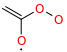

extended resonance structures for isomer, called newIsomers
Looping newIsomers. newIsomer is:


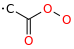

newIsomer is unique compared to 


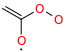


 isomorphic_isomers:



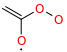


 isomers:



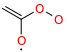

multiplicity 2
1 C u0 p0 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



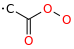

multiplicity 2
1 C u1 p1 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}

**************************
looping index 1
isomer is:


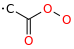

extended resonance structures for isomer, called newIsomers
Looping newIsomers. newIsomer is:


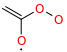

newIsomer is unique compared to 


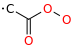


 isomorphic_isomers:



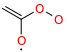


 isomers:



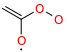

multiplicity 2
1 C u0 p0 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



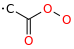

multiplicity 2
1 C u1 p1 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



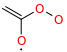

multiplicity 2
1 C u0 p1 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}

**************************
looping index 2
isomer is:


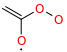

extended resonance structures for isomer, called newIsomers
Looping newIsomers. newIsomer is:


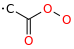

newIsomer is isomorphic with isom:


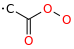


 isomorphic_isomers:



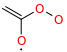

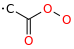


 isomers:



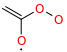

multiplicity 2
1 C u0 p0 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



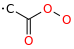

multiplicity 2
1 C u1 p1 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



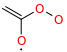

multiplicity 2
1 C u0 p1 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}

**************************
looping index 0
isomer is:


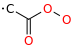

extended resonance structures for isomer, called newIsomers
Looping newIsomers. newIsomer is:


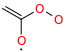

newIsomer is unique compared to 


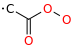


 isomorphic_isomers:



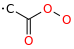


 isomers:



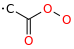

multiplicity 2
1 C u1 p0 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



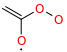

multiplicity 2
1 C u0 p1 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}

**************************
looping index 1
isomer is:


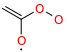

extended resonance structures for isomer, called newIsomers
Looping newIsomers. newIsomer is:


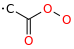

newIsomer is unique compared to 


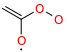


 isomorphic_isomers:



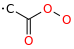


 isomers:



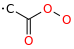

multiplicity 2
1 C u1 p0 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



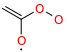

multiplicity 2
1 C u0 p1 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



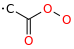

multiplicity 2
1 C u1 p1 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}

**************************
looping index 2
isomer is:


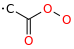

extended resonance structures for isomer, called newIsomers
Looping newIsomers. newIsomer is:


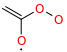

newIsomer is isomorphic with isom:


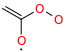


 isomorphic_isomers:



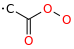

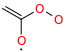


 isomers:



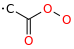

multiplicity 2
1 C u1 p0 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



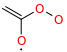

multiplicity 2
1 C u0 p1 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {5,S}
3 O u1 p2 c0 {2,S}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}



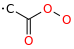

multiplicity 2
1 C u1 p1 c0 {2,S}
2 C u0 p0 c0 {1,S} {3,D} {5,S}
3 O u0 p2 c0 {2,D}
4 O u0 p2 c0 {5,S}
5 O u0 p2 c0 {2,S} {4,S}

aug_inchi_computed:  C2H3O3/c1-2(3)5-4/h4H,1H2/u1

OK!


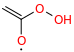

In [11]:
# inchiparsingTest.py, line 97, `def testC2H3O3(self):`
if True:
    if True:
        inchi = 'C2H3O3/c1-2(3)5-4/h4H,1H2'
        u_indices = [1]        
        
#self.compare(inchi, u_indices)
compare_tst(inchi, u_indices)

In [ ]:
# inchiparsingTest.py, line 98, `def testC2H3O3(self):`
if True:
    if True:
        inchi = 'C5H6O/c6-5-3-1-2-4-5/h1-3,5H,4H2'
        u_indices = [2, 6]        
        
#self.compare(inchi, u_indices)
compare_tst(inchi, u_indices)

In [ ]:
isomers